# Fashion-MNIST Experiment

In this notebook, I will use the [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset and build my own CNN from scratch. I'm following [this tutorial](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html?highlight=nn%20crossentropyloss), but typing it out myself and really understand what's going on at every line.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn 
import torch.nn.functional as F 

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

In [5]:
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

In [6]:
# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

In [7]:
# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


In [8]:
type(training_set)

torchvision.datasets.mnist.FashionMNIST

In [9]:
dataiter = iter(training_loader)
data = next(dataiter)
print(type(data))  # Should be a tuple or list
print(len(data))   # Should be 2 (images and labels)
images, labels = data
print(type(images))  # Should be a tensor
print(images.shape)  # Check the shape of the tensor
print(type(labels))  # Should be a tensor or list/array
print(labels.shape)  # Check the shape of the labels tensor

<class 'list'>
2
<class 'torch.Tensor'>
torch.Size([4, 1, 28, 28])
<class 'torch.Tensor'>
torch.Size([4])


Bag  Sandal  T-shirt/top  Pullover


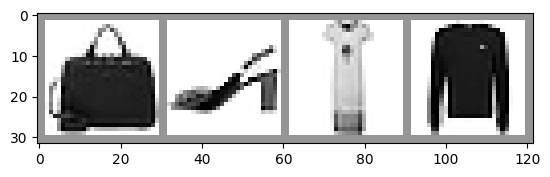

In [10]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

### Defining Model

In [18]:
# inheriting the Module class, which is a fundamental building block of any NN in PyTorch
class FashionClassifier(nn.Module):
    def __init__(self):
        # properly initiaitlizing the class by ensuring it is a super class
        super(FashionClassifier, self).__init__()

        # defining our first convolution
        self.conv1 = nn.Conv2d(
            in_channels=1, # number of input feature maps (btw channels=feature maps in this context)
            out_channels=6, # number of output feature maps (QUESTION: can I change this as a hyperparameter? how did they select 6?)
            kernel_size=5 # nxn size of kernel, in this case it's 5x5
            )
        # defining a pooling method
        self.pool = nn.MaxPool2d( # max pooling
            kernel_size=2, # using 2x2 kernel
            stride=2 
        )
        # defining our second convolution
        self.conv2 = nn.Conv2d(
            in_channels=6, # 6 input feature maps from conv1's output
            out_channels=16, # 16 output feature maps
            kernel_size=5 # again, 5x5 kernel
        )
        # defining our first fully-connected (dense) layer
        self.fc1 = nn.Linear(
            in_features=16*4*4, # 16 feature maps from the previous convolution, which are each of size 4*4 for a total of 256 features
            out_features=120
        )
        self.fc2 = nn.Linear(
            in_features=120, # again, taking as input 120 from the last FC layer's output
            out_features=84
        )
        self.fc3 = nn.Linear(
            in_features=84,
            out_features=10 # we have only 10 output features here because we have 10 classes
        )

    # defining our forward pass with the methods defined above
    def forward(self, x):
        # first block
        # conv1 -> ReLU -> maxPool
        x = self.pool(
            F.relu(
                self.conv1(x)
            )
        )
        # second block
        # conv2 -> ReLU -> maxPool
        x = self.pool(
            F.relu(
                self.conv2(x)
            )
        )
        x = x.view(
            # method to reshape the output tensor after convolutions into 2D
            -1, # -1 is a special parameter to automatically determine the batch size
            16 * 4 * 4 # this is  the size of the original tensor
        )
        # feeding the flattened feature map to the fully-connected layers
        # first FC layer
        # FC -> ReLU
        x = F.relu(
            self.fc1(x)
        )
        # same here
        x = F.relu(
            self.fc2(x)
        )
        # no ReLU on last layer
        x = self.fc3(x)

        return x

Ok so I think I better understand the architecture for this specific example. I learned about how the dimensions of the input/output feature maps evolve over the different layers. For now, I have left the exact architecture they specified in the [tutorial](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html?highlight=nn%20crossentropyloss), but I want to play with this architecture and see what happens. I will first continue with the tutorial as-is, and then experiment.

In [19]:
# instantiating the model
fashion_classifier_model = FashionClassifier()

### Defining Loss Function

In [20]:
loss_fn = torch.nn.CrossEntropyLoss() # why not binary cross-entropy? 

### Defining Optimizer

In [21]:
# they used SGD as their optimizer here
# why not any other optimzier?
optimizer = torch.optim.SGD(
    params=fashion_classifier_model.parameters(), # using all of model's parameters to optimize over
    lr=0.001, # this is the learning rate - experiment with this
    momentum=0.9 # setting momentum
    # what about other parameters? e.g. weight decay, dropout?
    # experiment with the params listed here, and also adding/removing combinations of hyperparams
)

### Defining Training Loop

In [22]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0
    last_loss = 0

    for i, data in enumerate(training_loader):
        inputs, labels = data
        # setting the gradients to zero for this run
        optimizer.zero_grad()
        # passing the data to the model as input
        outputs = fashion_classifier_model(inputs)
        # computing loss for outputs
        loss = loss_fn(outputs, labels)
        # performing back-propagation
        loss.backward()
        # adjusting weights
        optimizer.step()

        # recording data and printing to console
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000
            print(f"batch {i+1} loss: {last_loss}")
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar("Loss/train", last_loss, tb_x)
            running_loss = 0
    return last_loss

### Defining Epoch Loop

In [25]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f'runs/fashion_trainer_{timestamp}')
epoch_number = 0

# setting global variable of EPOCHS
EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print(f'Epoch {(epoch_number + 1)}:')
    fashion_classifier_model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    running_vloss = 0.0
    fashion_classifier_model.eval()

    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = fashion_classifier_model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss
        
    avg_vloss = running_vloss / (i + 1)
    print(f'LOSS train {avg_loss} valid {avg_vloss}')

    writer.add_scalars(
        'Training vs Validation Loss',
        {'Training':avg_loss, 'Validation':avg_vloss},
        epoch_number+1
    )
    writer.flush()

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f'../models/model_{timestamp}_{epoch_number}'
        torch.save(fashion_classifier_model.state_dict(), model_path)

    epoch_number += 1

Epoch 1:
batch 1000 loss: 0.24547620160983116
batch 2000 loss: 0.25997000668839065
batch 3000 loss: 0.25920666188115865
batch 4000 loss: 0.26747941748098036
batch 5000 loss: 0.2712163886357557
batch 6000 loss: 0.25745894092694654
batch 7000 loss: 0.25633522334253167
batch 8000 loss: 0.25864687859453056
batch 9000 loss: 0.25633405176803353
batch 10000 loss: 0.26053834167071727
batch 11000 loss: 0.26533620671688
batch 12000 loss: 0.2452705443614202
batch 13000 loss: 0.2575557631535212
batch 14000 loss: 0.2601004553446473
batch 15000 loss: 0.256349997115115
LOSS train 0.256349997115115 valid 0.3052155375480652
Epoch 2:
batch 1000 loss: 0.2284957202244077
batch 2000 loss: 0.2525983544543783
batch 3000 loss: 0.2503843576388726
batch 4000 loss: 0.24429637947289667
batch 5000 loss: 0.23718814242766928
batch 6000 loss: 0.23908485483687855
batch 7000 loss: 0.25146247519589227
batch 8000 loss: 0.25485871250147646
batch 9000 loss: 0.2741635209045589
batch 10000 loss: 0.23164373057127113
batch 110